# Nemeth Braille to MathML: Exploratory Data Analysis

This notebook analyzes the evaluation results from the Nemeth braille to MathML translation task using o3-mini model.

**Dataset**: 200 samples from January 12, 2026 results  
**Overall Success Rate**: ~60.00%

## Key Questions:
1. What is the overall success rate?
2. *How does success rate vary by braille size?*  ⭐
3. What other patterns can we identify in the data?

## Key Finding:
**There's a clear inverse relationship between braille length and success rate:**
- Short expressions (1-5 chars): **81.48% success** ✅
- Medium expressions (6-15 chars): **57.69-67.24% success** 🟡  
- Longer expressions (16+ chars): **43.75-50.00% success** ❌

This suggests the model struggles significantly with longer, more complex mathematical expressions.

**Note**: All floating point numbers in this notebook are displayed with 2 decimal places for consistency.

In [20]:
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# Format all floats to 2 decimal places
pd.options.display.float_format = '{:.2f}'.format
pl.Config.set_float_precision(2)

polars.config.Config

## 1. Load and Inspect Data

In [21]:
# Load the data from the larger results file (200 samples with ~60% success rate)
df = pl.read_csv('results/nemeth_mathml_evaluation_results_20260112_230552.csv')

# Basic info
print(f"Total samples: {len(df)}")
print(f"\nColumns: {df.columns}")
print(f"\nData types:")
print(df.schema)

Total samples: 200

Columns: ['id', 'source_file', 'line_number', 'nemeth_braille', 'nemeth_length', 'ground_truth_mathml', 'ground_truth_length', 'is_equal', 'predicted_mathml', 'prompt', 'model_name', 'timestamp', 'prompt_tokens', 'completion_tokens', 'total_tokens', 'reasoning_tokens', 'reasoning_effort', 'response_time_seconds', 'few_shot_example_indices', 'error']

Data types:
Schema({'id': Int64, 'source_file': String, 'line_number': Int64, 'nemeth_braille': String, 'nemeth_length': Int64, 'ground_truth_mathml': String, 'ground_truth_length': Int64, 'is_equal': Boolean, 'predicted_mathml': String, 'prompt': String, 'model_name': String, 'timestamp': String, 'prompt_tokens': Int64, 'completion_tokens': Int64, 'total_tokens': Int64, 'reasoning_tokens': String, 'reasoning_effort': String, 'response_time_seconds': Float64, 'few_shot_example_indices': String, 'error': String})


In [39]:
# Display first few rows
df.head(5)

id,source_file,line_number,nemeth_braille,nemeth_length,ground_truth_mathml,ground_truth_length,is_equal,predicted_mathml,prompt,model_name,timestamp,prompt_tokens,completion_tokens,total_tokens,reasoning_tokens,reasoning_effort,response_time_seconds,few_shot_example_indices,error
i64,str,i64,str,i64,str,i64,bool,str,str,str,str,i64,i64,i64,str,str,f64,str,str
1,"""PreCalculus 2e-no-dups.brls""",7546,"""⠉⠕⠎⠀⠷⠂⠢⠴⠨⠡⠾""",11,"""<math><mrow><mi>cos</mi><mo st…",105,true,"""<math xmlns=""http://www.w3.org…","""You are an expert in Nemeth Br…","""gpt-5.2-2025-12-11""","""2026-01-12T23:05:58.935993+00:…",18610,73,18683,null,null,6.54,"""[""Nemeth.brls:76"", ""Nemeth.brl…",null
2,"""Algebra and Trigonometry 2e-no…",7701,"""⠋⠷⠭⠾⠀⠨⠅⠀⠼⠆⠭⠘⠒⠐⠬⠢⠭⠘⠆⠐⠤⠂⠂⠭⠬⠲⠨""",27,"""<math><mrow><mi>f</mi><mo stre…",258,false,"""<math xmlns=""http://www.w3.org…","""You are an expert in Nemeth Br…","""gpt-5.2-2025-12-11""","""2026-01-12T23:05:58.844113+00:…",18656,165,18821,null,null,6.27,"""[""Nemeth.brls:172"", ""Nemeth.br…",null
3,"""Intermediate Algebra_50_ Funct…",3833,"""⠤⠼⠆⠨⠲⠴""",6,"""<math xmlns=""http://www.w3.org…",79,true,"""<math xmlns=""http://www.w3.org…","""You are an expert in Nemeth Br…","""gpt-5.2-2025-12-11""","""2026-01-12T23:05:57.398014+00:…",18597,37,18634,null,null,4.82,"""[""Nemeth.brls:169"", ""Nemeth.br…",null
4,"""Elementary Algebra 2e-no-dups.…",8028,"""⠏⠘⠆""",3,"""<math><msup><mi>p</mi><mn>2</m…",46,true,"""<math xmlns=""http://www.w3.org…","""You are an expert in Nemeth Br…","""gpt-5.2-2025-12-11""","""2026-01-12T23:05:58.362903+00:…",18588,42,18630,null,null,5.78,"""[""Nemeth.brls:137"", ""Nemeth.br…",null
5,"""PreAlgebra 2e-no-dups.brls""",4256,"""⠼⠂⠡⠆⠔⠀⠨⠅⠀⠼⠆⠔""",12,"""<math><mrow><mspace width=""0.2…",109,false,"""<math xmlns=""http://www.w3.org…","""You are an expert in Nemeth Br…","""gpt-5.2-2025-12-11""","""2026-01-12T23:05:57.706371+00:…",18611,63,18674,null,null,5.12,"""[""Nemeth.brls:161"", ""Nemeth.br…",null


In [23]:
# Basic statistics
df.select([
    'nemeth_length',
    'ground_truth_length',
    'prompt_tokens',
    'completion_tokens',
    'total_tokens',
    'response_time_seconds'
]).describe()

statistic,nemeth_length,ground_truth_length,prompt_tokens,completion_tokens,total_tokens,response_time_seconds
str,f64,f64,f64,f64,f64,f64
"""count""",200.00,200.00,200.00,200.00,200.00,200.00
"""null_count""",0.00,0.00,0.00,0.00,0.00,0.00
"""mean""",12.99,131.38,18615.20,74.50,18689.70,5.45
"""std""",7.24,66.39,19.90,36.26,53.43,0.88
"""min""",2.00,23.00,18585.00,29.00,18615.00,3.00
"""25%""",8.00,79.00,18601.00,48.00,18648.00,4.88
"""50%""",12.00,120.00,18611.00,64.00,18677.00,5.39
"""75%""",17.00,180.00,18627.00,94.00,18722.00,5.95
"""max""",36.00,298.00,18681.00,241.00,18892.00,8.23


## 2. Overall Success Rate

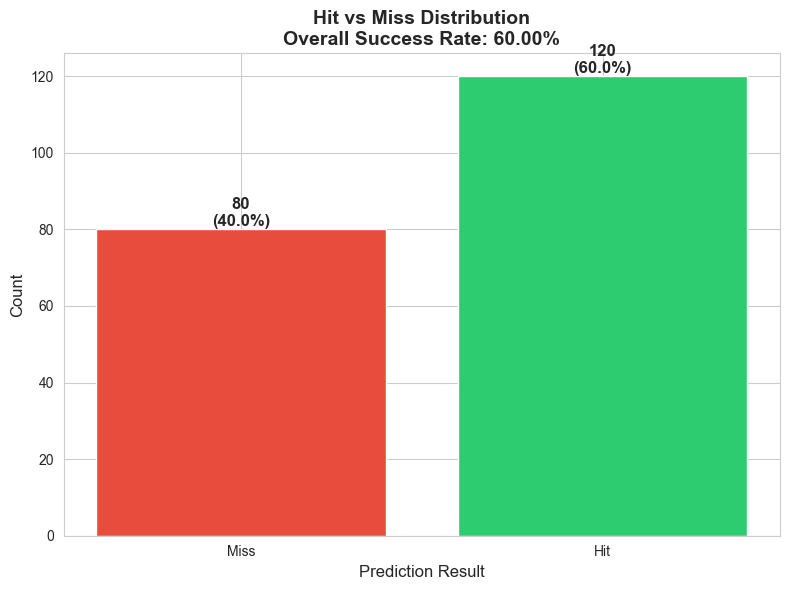

In [42]:
# Calculate overall success rate
success_rate = df['is_equal'].mean() * 100
total_correct = df['is_equal'].sum()
total_samples = len(df)

# Visualize
fig, ax = plt.subplots(figsize=(8, 6))
counts = df['is_equal'].value_counts().sort('is_equal')
counts_pd = counts.to_pandas()

colors = ['#e74c3c', '#2ecc71']  # Red for False, Green for True
bars = ax.bar(counts_pd['is_equal'].map({False: 'Miss', True: 'Hit'}), 
              counts_pd['count'],
              color=colors)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({height/total_samples*100:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_ylabel('Count', fontsize=12)
ax.set_xlabel('Prediction Result', fontsize=12)
ax.set_title(f'Hit vs Miss Distribution\nOverall Success Rate: {success_rate:.2f}%', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Success Rate by Braille Size

In [25]:
# Create braille length bins using when/then logic (more reliable than cut)
df_with_bins = df.with_columns([
    pl.when(pl.col('nemeth_length') <= 5).then(pl.lit('1-5'))
    .when(pl.col('nemeth_length') <= 10).then(pl.lit('6-10'))
    .when(pl.col('nemeth_length') <= 15).then(pl.lit('11-15'))
    .when(pl.col('nemeth_length') <= 20).then(pl.lit('16-20'))
    .when(pl.col('nemeth_length') <= 25).then(pl.lit('21-25'))
    .otherwise(pl.lit('26+')).alias('length_bin')
])

# Calculate success rate by bin
success_by_length = df_with_bins.group_by('length_bin').agg([
    pl.col('is_equal').mean().alias('success_rate'),
    pl.len().alias('count')
]).sort('count', descending=True)  # Sort by count to see most common bins first

print("Success Rate by Braille Length:")
print(success_by_length)

Success Rate by Braille Length:
shape: (6, 3)
┌────────────┬──────────────┬───────┐
│ length_bin ┆ success_rate ┆ count │
│ ---        ┆ ---          ┆ ---   │
│ str        ┆ f64          ┆ u32   │
╞════════════╪══════════════╪═══════╡
│ 6-10       ┆ 0.67         ┆ 58    │
│ 11-15      ┆ 0.58         ┆ 52    │
│ 16-20      ┆ 0.44         ┆ 32    │
│ 1-5        ┆ 0.81         ┆ 27    │
│ 26+        ┆ 0.50         ┆ 16    │
│ 21-25      ┆ 0.47         ┆ 15    │
└────────────┴──────────────┴───────┘


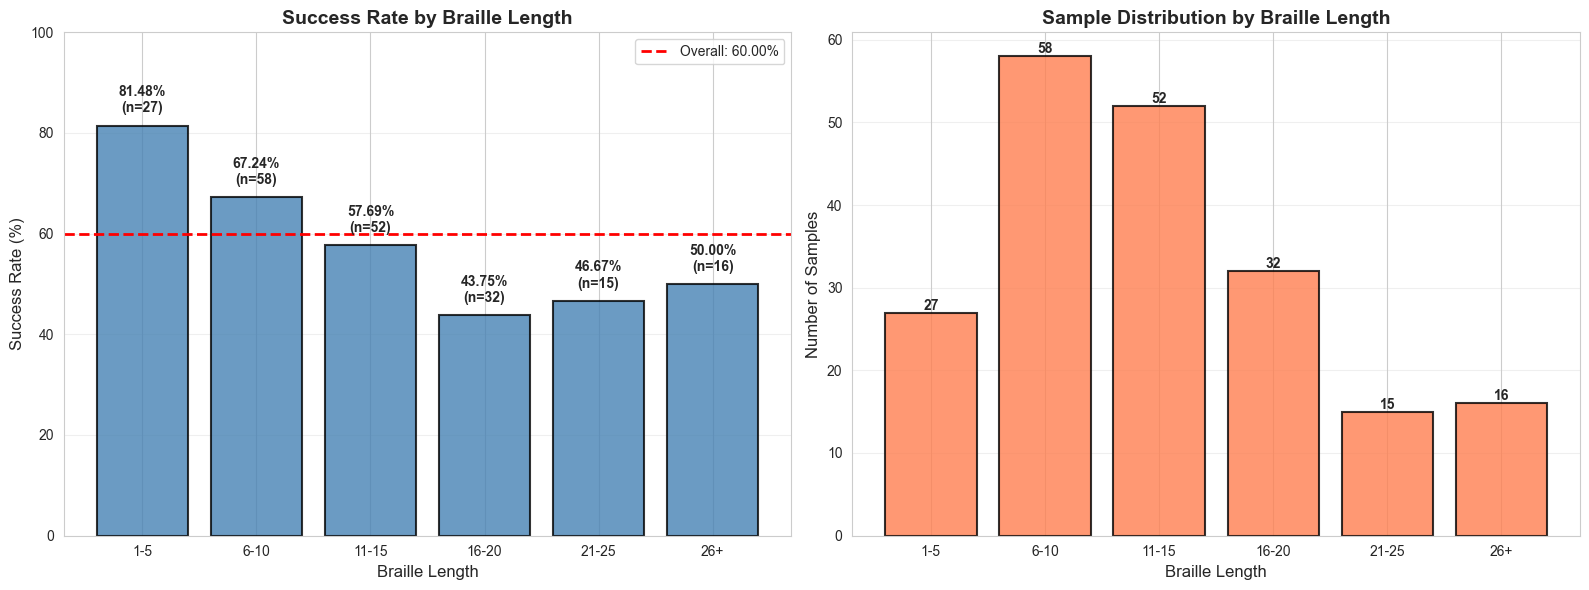

In [26]:
# Visualize success rate by braille length bins
import pandas as pd

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Convert to pandas and sort by bin order
success_pd = success_by_length.to_pandas()
success_pd = success_pd.dropna()  # Remove any null bins

# Sort bins in logical order
bin_order = ['1-5', '6-10', '11-15', '16-20', '21-25', '26+']
success_pd['length_bin'] = pd.Categorical(success_pd['length_bin'], 
                                           categories=bin_order, 
                                           ordered=True)
success_pd = success_pd.sort_values('length_bin')

# Plot 1: Success rate by bin
bars1 = ax1.bar(success_pd['length_bin'], success_pd['success_rate'] * 100, 
                color='steelblue', alpha=0.8, edgecolor='black', linewidth=1.5)
ax1.set_ylabel('Success Rate (%)', fontsize=12)
ax1.set_xlabel('Braille Length', fontsize=12)
ax1.set_title('Success Rate by Braille Length', fontsize=14, fontweight='bold')
ax1.axhline(y=success_rate, color='red', linestyle='--', linewidth=2,
            label=f'Overall: {success_rate:.2f}%')
ax1.legend()
ax1.set_ylim(0, 100)
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars1):
    height = bar.get_height()
    if not np.isnan(height):
        count = success_pd.iloc[i]['count']
        ax1.text(bar.get_x() + bar.get_width()/2., height + 2,
                f'{height:.2f}%\n(n={count})',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 2: Sample count by bin
bars2 = ax2.bar(success_pd['length_bin'], success_pd['count'], 
                color='coral', alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Number of Samples', fontsize=12)
ax2.set_xlabel('Braille Length', fontsize=12)
ax2.set_title('Sample Distribution by Braille Length', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

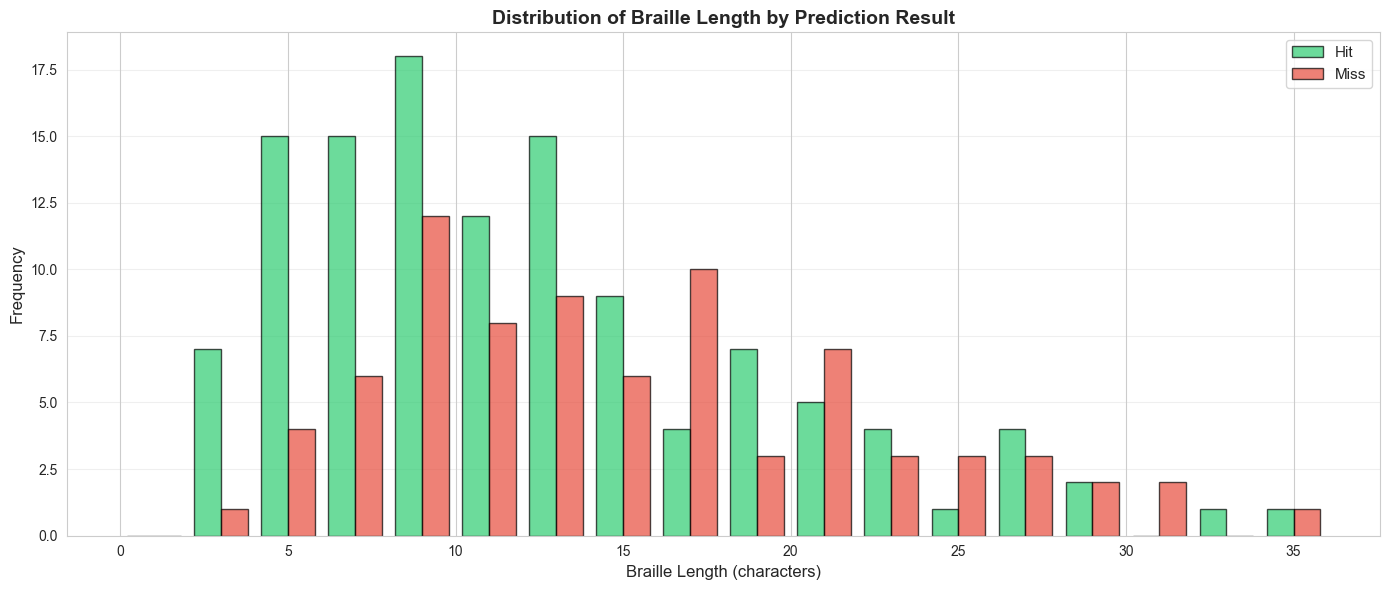

In [27]:
# Histogram of braille length colored by success/failure
fig, ax = plt.subplots(figsize=(14, 6))

df_pd = df.to_pandas()
hits = df_pd[df_pd['is_equal'] == True]['nemeth_length']
misses = df_pd[df_pd['is_equal'] == False]['nemeth_length']

bins = range(0, df_pd['nemeth_length'].max() + 2, 2)
ax.hist([hits, misses], bins=bins, label=['Hit', 'Miss'], 
        color=['#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')

ax.set_xlabel('Braille Length (characters)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Braille Length by Prediction Result', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Response Time Analysis

In [28]:
# Response time statistics
print("Response Time Statistics:")
print(df.select('response_time_seconds').describe())

# Compare response times for hits vs misses
response_by_result = df.group_by('is_equal').agg([
    pl.col('response_time_seconds').mean().alias('avg_response_time'),
    pl.col('response_time_seconds').median().alias('median_response_time'),
    pl.col('response_time_seconds').std().alias('std_response_time')
])

print("\nResponse Time by Result:")
print(response_by_result)

Response Time Statistics:
shape: (9, 2)
┌────────────┬───────────────────────┐
│ statistic  ┆ response_time_seconds │
│ ---        ┆ ---                   │
│ str        ┆ f64                   │
╞════════════╪═══════════════════════╡
│ count      ┆ 200.00                │
│ null_count ┆ 0.00                  │
│ mean       ┆ 5.45                  │
│ std        ┆ 0.88                  │
│ min        ┆ 3.00                  │
│ 25%        ┆ 4.88                  │
│ 50%        ┆ 5.39                  │
│ 75%        ┆ 5.95                  │
│ max        ┆ 8.23                  │
└────────────┴───────────────────────┘

Response Time by Result:
shape: (2, 4)
┌──────────┬───────────────────┬──────────────────────┬───────────────────┐
│ is_equal ┆ avg_response_time ┆ median_response_time ┆ std_response_time │
│ ---      ┆ ---               ┆ ---                  ┆ ---               │
│ bool     ┆ f64               ┆ f64                  ┆ f64               │
╞══════════╪═══════════════════

/var/folders/25/22j442jd1kbbtszy07f7l15h0000gn/T/ipykernel_25742/4075532068.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(['Miss', 'Hit'])


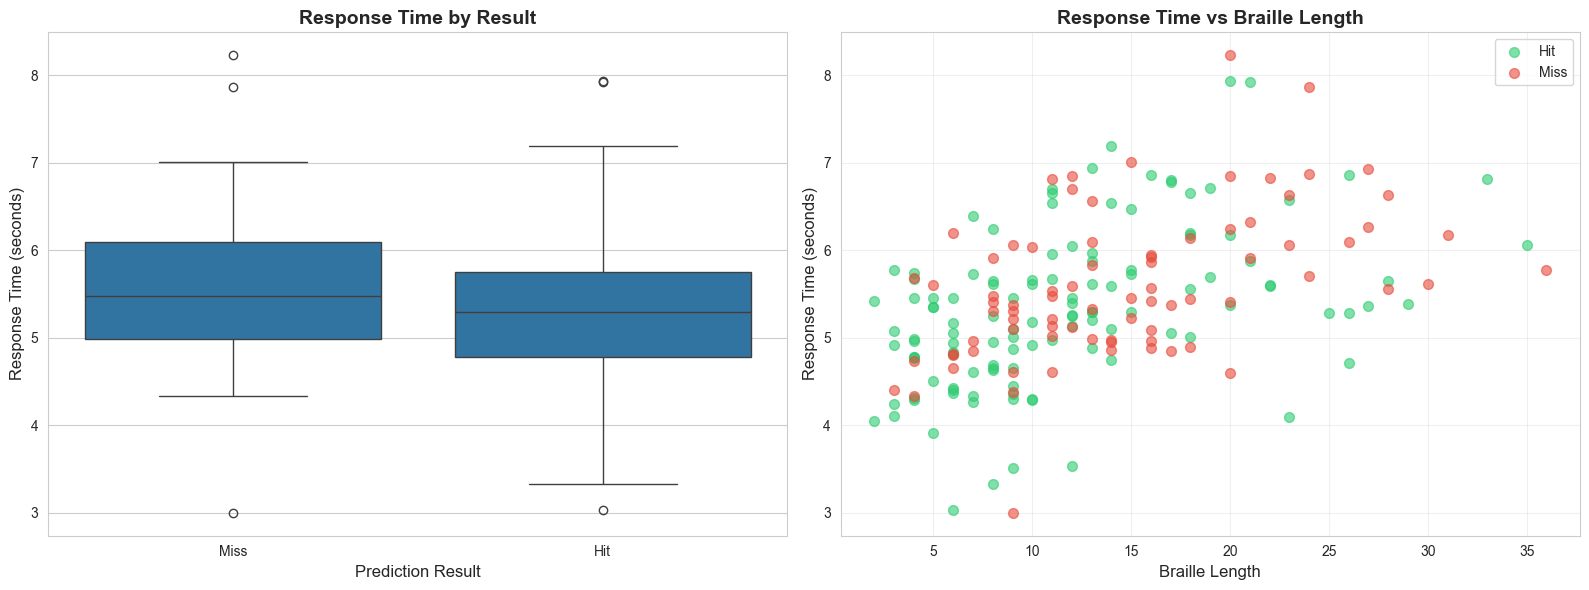

In [29]:
# Visualize response time distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Box plot
df_pd = df.to_pandas()
sns.boxplot(data=df_pd, x='is_equal', y='response_time_seconds', ax=axes[0])
axes[0].set_xticklabels(['Miss', 'Hit'])
axes[0].set_xlabel('Prediction Result', fontsize=12)
axes[0].set_ylabel('Response Time (seconds)', fontsize=12)
axes[0].set_title('Response Time by Result', fontsize=14, fontweight='bold')

# Scatter plot: braille length vs response time
hits_pd = df_pd[df_pd['is_equal'] == True]
misses_pd = df_pd[df_pd['is_equal'] == False]

axes[1].scatter(hits_pd['nemeth_length'], hits_pd['response_time_seconds'], 
               alpha=0.6, s=50, label='Hit', color='#2ecc71')
axes[1].scatter(misses_pd['nemeth_length'], misses_pd['response_time_seconds'], 
               alpha=0.6, s=50, label='Miss', color='#e74c3c')
axes[1].set_xlabel('Braille Length', fontsize=12)
axes[1].set_ylabel('Response Time (seconds)', fontsize=12)
axes[1].set_title('Response Time vs Braille Length', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Token Usage Analysis

In [30]:
# Token statistics by result
token_stats = df.group_by('is_equal').agg([
    pl.col('prompt_tokens').mean().alias('avg_prompt_tokens'),
    pl.col('completion_tokens').mean().alias('avg_completion_tokens'),
    pl.col('total_tokens').mean().alias('avg_total_tokens')
])

print("Token Usage by Result:")
print(token_stats)

Token Usage by Result:
shape: (2, 4)
┌──────────┬───────────────────┬───────────────────────┬──────────────────┐
│ is_equal ┆ avg_prompt_tokens ┆ avg_completion_tokens ┆ avg_total_tokens │
│ ---      ┆ ---               ┆ ---                   ┆ ---              │
│ bool     ┆ f64               ┆ f64                   ┆ f64              │
╞══════════╪═══════════════════╪═══════════════════════╪══════════════════╡
│ true     ┆ 18611.85          ┆ 70.76                 ┆ 18682.61         │
│ false    ┆ 18620.22          ┆ 80.11                 ┆ 18700.34         │
└──────────┴───────────────────┴───────────────────────┴──────────────────┘


/var/folders/25/22j442jd1kbbtszy07f7l15h0000gn/T/ipykernel_25742/2797539167.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1, 1].set_xticklabels(['Miss', 'Hit'])


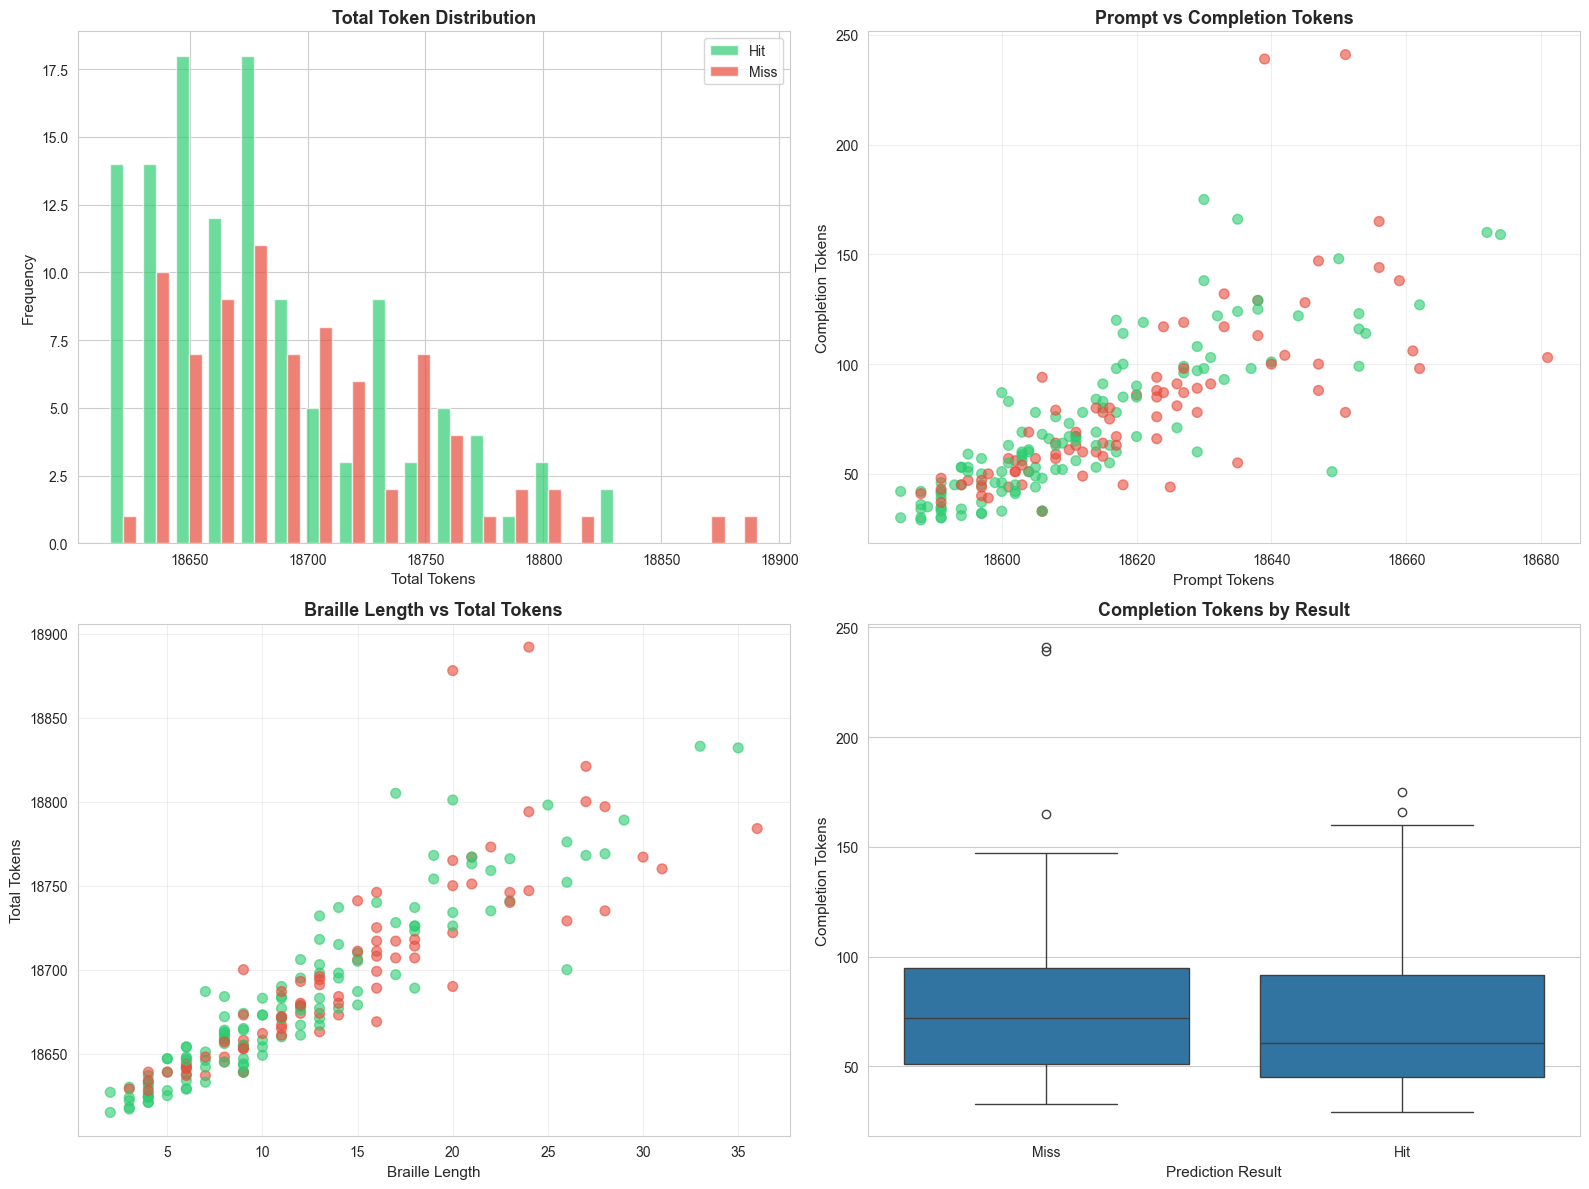

In [31]:
# Visualize token usage
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

df_pd = df.to_pandas()

# Plot 1: Total tokens distribution
axes[0, 0].hist([df_pd[df_pd['is_equal'] == True]['total_tokens'],
                 df_pd[df_pd['is_equal'] == False]['total_tokens']], 
                bins=20, label=['Hit', 'Miss'], 
                color=['#2ecc71', '#e74c3c'], alpha=0.7)
axes[0, 0].set_xlabel('Total Tokens', fontsize=11)
axes[0, 0].set_ylabel('Frequency', fontsize=11)
axes[0, 0].set_title('Total Token Distribution', fontsize=13, fontweight='bold')
axes[0, 0].legend()

# Plot 2: Prompt vs Completion tokens
axes[0, 1].scatter(df_pd['prompt_tokens'], df_pd['completion_tokens'],
                  c=df_pd['is_equal'].map({True: '#2ecc71', False: '#e74c3c'}),
                  alpha=0.6, s=50)
axes[0, 1].set_xlabel('Prompt Tokens', fontsize=11)
axes[0, 1].set_ylabel('Completion Tokens', fontsize=11)
axes[0, 1].set_title('Prompt vs Completion Tokens', fontsize=13, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# Plot 3: Braille length vs total tokens
axes[1, 0].scatter(df_pd['nemeth_length'], df_pd['total_tokens'],
                  c=df_pd['is_equal'].map({True: '#2ecc71', False: '#e74c3c'}),
                  alpha=0.6, s=50)
axes[1, 0].set_xlabel('Braille Length', fontsize=11)
axes[1, 0].set_ylabel('Total Tokens', fontsize=11)
axes[1, 0].set_title('Braille Length vs Total Tokens', fontsize=13, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 4: Completion tokens box plot
sns.boxplot(data=df_pd, x='is_equal', y='completion_tokens', ax=axes[1, 1])
axes[1, 1].set_xticklabels(['Miss', 'Hit'])
axes[1, 1].set_xlabel('Prediction Result', fontsize=11)
axes[1, 1].set_ylabel('Completion Tokens', fontsize=11)
axes[1, 1].set_title('Completion Tokens by Result', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Source File Analysis

In [32]:
# Success rate by source file
source_stats = df.group_by('source_file').agg([
    pl.col('is_equal').mean().alias('success_rate'),
    pl.len().alias('count')
]).sort('count', descending=True)

print("Top 10 Source Files by Sample Count:")
print(source_stats.head(10))

Top 10 Source Files by Sample Count:
shape: (10, 3)
┌─────────────────────────────────┬──────────────┬───────┐
│ source_file                     ┆ success_rate ┆ count │
│ ---                             ┆ ---          ┆ ---   │
│ str                             ┆ f64          ┆ u32   │
╞═════════════════════════════════╪══════════════╪═══════╡
│ Algebra and Trigonometry 2e-no… ┆ 0.56         ┆ 27    │
│ Elementary Algebra 2e-no-dups.… ┆ 0.75         ┆ 24    │
│ PreAlgebra 2e-no-dups.brls      ┆ 0.61         ┆ 23    │
│ PreCalculus 2e-no-dups.brls     ┆ 0.48         ┆ 23    │
│ Modeling, Functions, and Graph… ┆ 0.55         ┆ 22    │
│ Intermediate Algebra 2e-no-dup… ┆ 0.64         ┆ 22    │
│ College Algebra 2e with Corequ… ┆ 0.59         ┆ 17    │
│ Contemporary Mathematics-no-du… ┆ 0.55         ┆ 11    │
│ Intermediate Algebra_50_ Funct… ┆ 0.57         ┆ 7     │
│ Elementary Algebra-no-dups.brl… ┆ 0.71         ┆ 7     │
└─────────────────────────────────┴──────────────┴───────┘


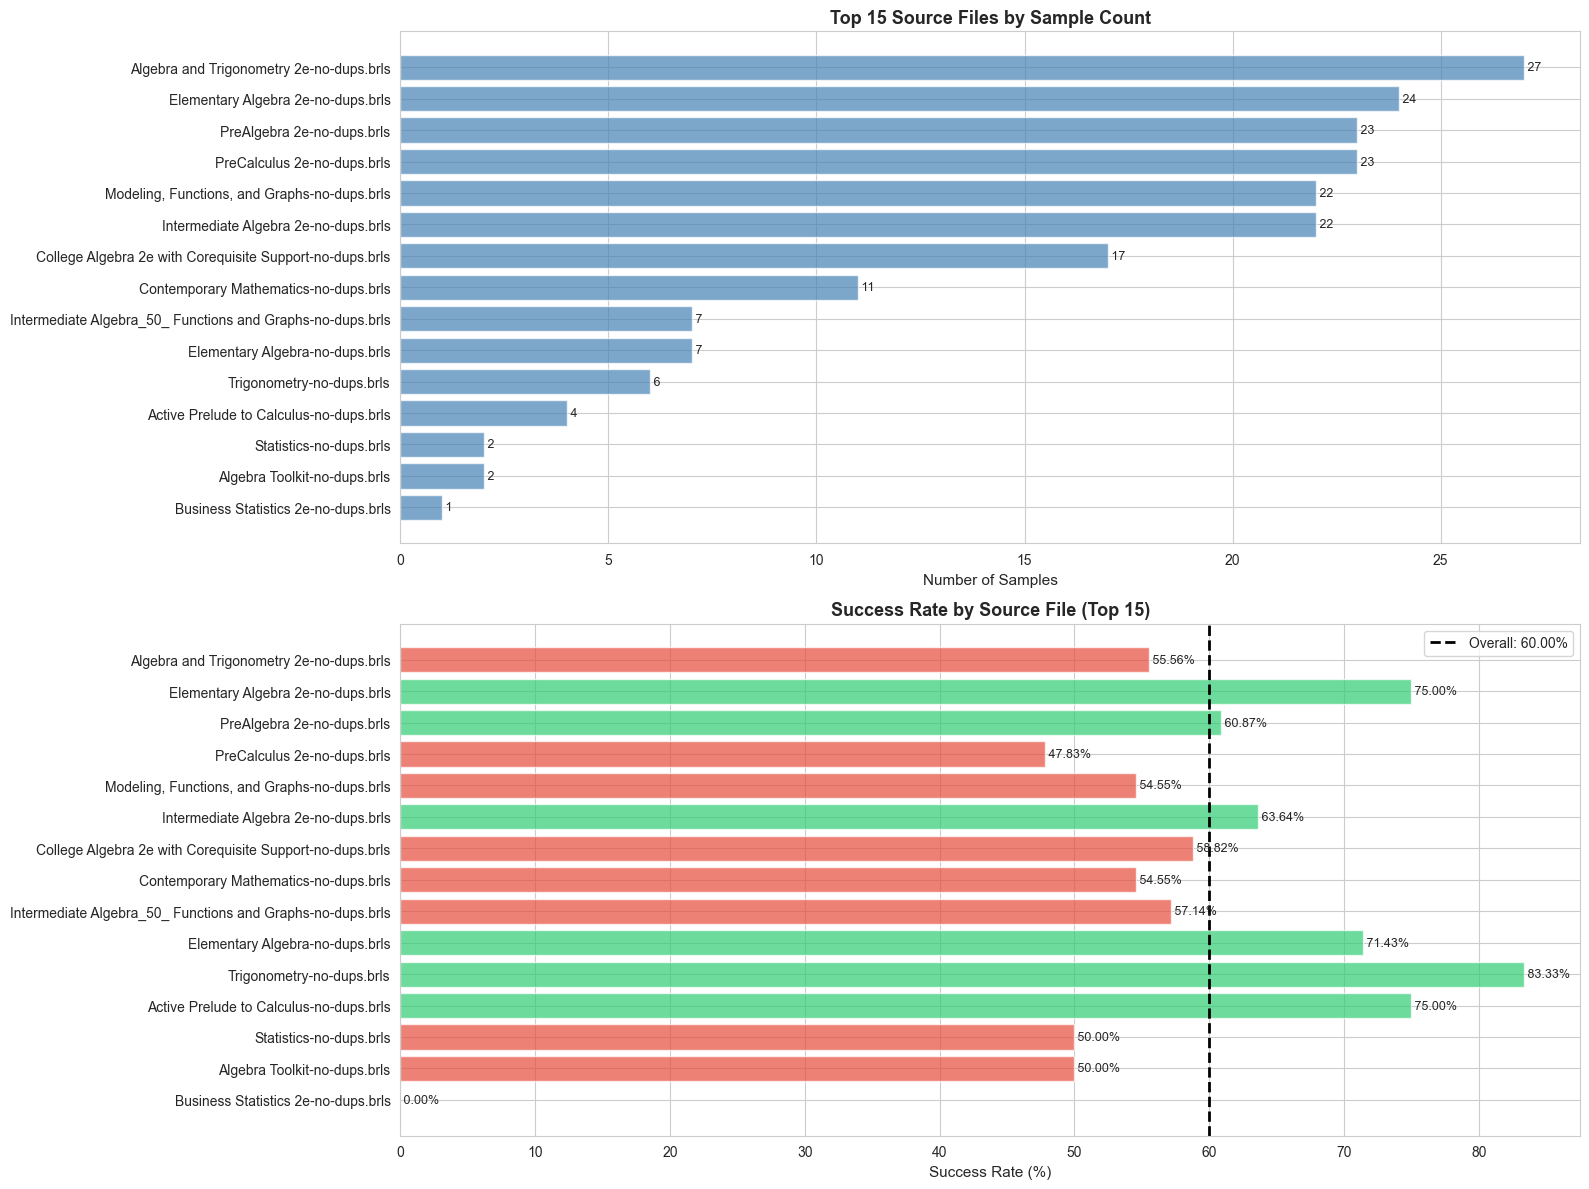

In [33]:
# Visualize source file distribution (top 15)
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

top_sources = source_stats.head(15).to_pandas()

# Plot 1: Sample count
axes[0].barh(range(len(top_sources)), top_sources['count'], color='steelblue', alpha=0.7)
axes[0].set_yticks(range(len(top_sources)))
axes[0].set_yticklabels(top_sources['source_file'], fontsize=10)
axes[0].set_xlabel('Number of Samples', fontsize=11)
axes[0].set_title('Top 15 Source Files by Sample Count', fontsize=13, fontweight='bold')
axes[0].invert_yaxis()

# Add value labels
for i, v in enumerate(top_sources['count']):
    axes[0].text(v, i, f' {v}', va='center', fontsize=9)

# Plot 2: Success rate
colors = ['#2ecc71' if rate >= 0.6 else '#e74c3c' for rate in top_sources['success_rate']]
axes[1].barh(range(len(top_sources)), top_sources['success_rate'] * 100, 
            color=colors, alpha=0.7)
axes[1].set_yticks(range(len(top_sources)))
axes[1].set_yticklabels(top_sources['source_file'], fontsize=10)
axes[1].set_xlabel('Success Rate (%)', fontsize=11)
axes[1].set_title('Success Rate by Source File (Top 15)', fontsize=13, fontweight='bold')
axes[1].axvline(x=success_rate, color='black', linestyle='--', linewidth=2, 
               label=f'Overall: {success_rate:.2f}%')
axes[1].legend()
axes[1].invert_yaxis()

# Add value labels
for i, v in enumerate(top_sources['success_rate'] * 100):
    axes[1].text(v, i, f' {v:.2f}%', va='center', fontsize=9)

plt.tight_layout()
plt.show()

## 7. MathML Length Analysis

/var/folders/25/22j442jd1kbbtszy07f7l15h0000gn/T/ipykernel_25742/4191858191.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(['Miss', 'Hit'])


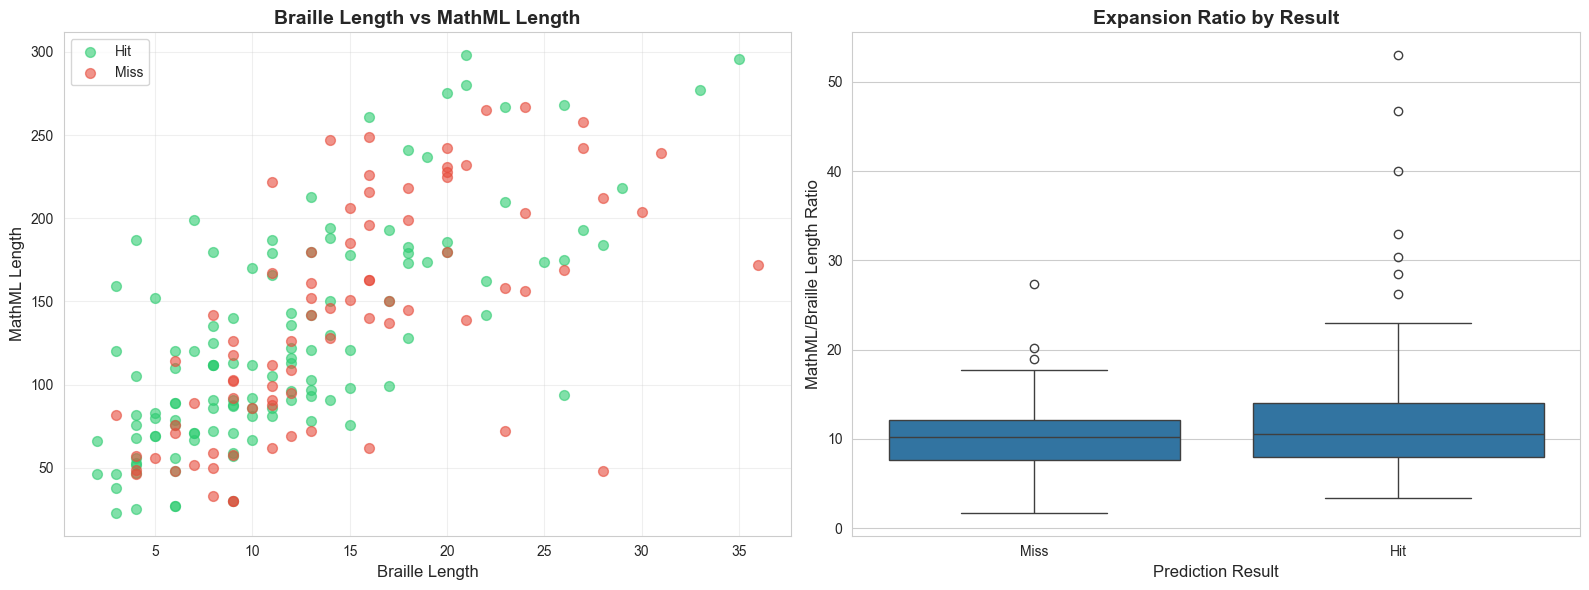


Average expansion ratio: 11.61
Median expansion ratio: 10.20


In [34]:
# Relationship between braille length and MathML length
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

df_pd = df.to_pandas()

# Scatter plot
hits_pd = df_pd[df_pd['is_equal'] == True]
misses_pd = df_pd[df_pd['is_equal'] == False]

axes[0].scatter(hits_pd['nemeth_length'], hits_pd['ground_truth_length'], 
               alpha=0.6, s=50, label='Hit', color='#2ecc71')
axes[0].scatter(misses_pd['nemeth_length'], misses_pd['ground_truth_length'], 
               alpha=0.6, s=50, label='Miss', color='#e74c3c')
axes[0].set_xlabel('Braille Length', fontsize=12)
axes[0].set_ylabel('MathML Length', fontsize=12)
axes[0].set_title('Braille Length vs MathML Length', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Calculate expansion ratio
df_with_ratio = df.with_columns(
    (pl.col('ground_truth_length') / pl.col('nemeth_length')).alias('expansion_ratio')
)

# Box plot of expansion ratio
ratio_pd = df_with_ratio.to_pandas()
sns.boxplot(data=ratio_pd, x='is_equal', y='expansion_ratio', ax=axes[1])
axes[1].set_xticklabels(['Miss', 'Hit'])
axes[1].set_xlabel('Prediction Result', fontsize=12)
axes[1].set_ylabel('MathML/Braille Length Ratio', fontsize=12)
axes[1].set_title('Expansion Ratio by Result', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

avg_ratio = df_with_ratio['expansion_ratio'].mean()
median_ratio = df_with_ratio['expansion_ratio'].median()
print(f"\nAverage expansion ratio: {avg_ratio:.2f}")
print(f"Median expansion ratio: {median_ratio:.2f}")

## 8. Error Analysis

In [35]:
# Check if there are any errors
errors = df.filter(pl.col('error').is_not_null())
print(f"Number of samples with errors: {len(errors)}")

if len(errors) > 0:
    print("\nError samples:")
    print(errors.select(['id', 'nemeth_braille', 'error']))
else:
    print("\nNo errors found in the dataset.")

Number of samples with errors: 0

No errors found in the dataset.


In [36]:
# Show some examples of successful predictions
print("=" * 80)
print("EXAMPLES OF SUCCESSFUL PREDICTIONS (HITS)")
print("=" * 80)

hits = df.filter(pl.col('is_equal') == True).head(3)

for i, row in enumerate(hits.iter_rows(named=True), 1):
    print(f"\n--- Example {i} ---")
    print(f"Braille: {row['nemeth_braille']}")
    print(f"Braille Length: {row['nemeth_length']}")
    print(f"Source: {row['source_file']}:{row['line_number']}")
    print(f"Ground Truth MathML (first 200 chars): {row['ground_truth_mathml'][:200]}")
    print(f"Response Time: {row['response_time_seconds']:.2f}s")
    print(f"Total Tokens: {row['total_tokens']}")

EXAMPLES OF SUCCESSFUL PREDICTIONS (HITS)

--- Example 1 ---
Braille: ⠉⠕⠎⠀⠷⠂⠢⠴⠨⠡⠾
Braille Length: 11
Source: PreCalculus 2e-no-dups.brls:7546
Ground Truth MathML (first 200 chars): <math><mrow><mi>cos</mi><mo stretchy="false">(</mo><mn>150°</mn><mo stretchy="false">)</mo></mrow></math>
Response Time: 6.54s
Total Tokens: 18683

--- Example 2 ---
Braille: ⠤⠼⠆⠨⠲⠴
Braille Length: 6
Source: Intermediate Algebra_50_ Functions and Graphs-no-dups.brls:3833
Ground Truth MathML (first 200 chars): <math xmlns="http://www.w3.org/1998/Math/MathML"><mo>−</mo><mn>2.40</mn></math>
Response Time: 4.82s
Total Tokens: 18634

--- Example 3 ---
Braille: ⠏⠘⠆
Braille Length: 3
Source: Elementary Algebra 2e-no-dups.brls:8028
Ground Truth MathML (first 200 chars): <math><msup><mi>p</mi><mn>2</mn></msup></math>
Response Time: 5.78s
Total Tokens: 18630


In [37]:
# Show some examples of failed predictions
print("=" * 80)
print("EXAMPLES OF FAILED PREDICTIONS (MISSES)")
print("=" * 80)

misses = df.filter(pl.col('is_equal') == False).head(5)

for i, row in enumerate(misses.iter_rows(named=True), 1):
    print(f"\n--- Example {i} ---")
    print(f"Braille: {row['nemeth_braille']}")
    print(f"Braille Length: {row['nemeth_length']}")
    print(f"Source: {row['source_file']}:{row['line_number']}")
    print(f"\nGround Truth MathML (first 200 chars):\n{row['ground_truth_mathml'][:200]}")
    print(f"\nPredicted MathML (first 200 chars):\n{row['predicted_mathml'][:200]}")
    print(f"\nResponse Time: {row['response_time_seconds']:.2f}s")
    print(f"Total Tokens: {row['total_tokens']}")

EXAMPLES OF FAILED PREDICTIONS (MISSES)

--- Example 1 ---
Braille: ⠋⠷⠭⠾⠀⠨⠅⠀⠼⠆⠭⠘⠒⠐⠬⠢⠭⠘⠆⠐⠤⠂⠂⠭⠬⠲⠨
Braille Length: 27
Source: Algebra and Trigonometry 2e-no-dups.brls:7701

Ground Truth MathML (first 200 chars):
<math><mrow><mi>f</mi><mo stretchy="false">(</mo><mi>x</mi><mo stretchy="false">)</mo><mo>=</mo><mn>2</mn><msup><mi>x</mi><mn>3</mn></msup><mo>+</mo><mn>5</mn><msup><mi>x</mi><mn>2</mn></msup><mo>−</m

Predicted MathML (first 200 chars):
<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>f</mi><mo>(</mo><mi>x</mi><mo>)</mo><mo>=</mo><mn>2</mn><mo>&#x2062;</mo><msup><mi>x</mi><mn>3</mn></msup><mo>+</mo><mn>5</mn><mo>&#x2062;</m

Response Time: 6.27s
Total Tokens: 18821

--- Example 2 ---
Braille: ⠼⠂⠡⠆⠔⠀⠨⠅⠀⠼⠆⠔
Braille Length: 12
Source: PreAlgebra 2e-no-dups.brls:4256

Ground Truth MathML (first 200 chars):
<math><mrow><mspace width="0.2em"></mspace><mn>1</mn><mo>·</mo><mn>29</mn><mo>=</mo><mn>29</mn></mrow></math>

Predicted MathML (first 200 chars):
<math xmlns="http://www